# MNIST Code Along with CNN

Now that we've seen the results of an artificial neural network model on the MNIST dataset, let's work the same
data with a Convolutional Neural Network (CNN). Make sure to watch the theory lectures! You'll want to be
comfortable with:
    
* convolutional layers
* filters/kernels
* pooling
* depth, stride and zero-padding

Note that in this exercise there is no need to flatten the MNIST data, as a CNN expects 2-dimensional data.

### Perform standard imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

### Load the MNIST dataset
PyTorch makes the MNIST train and test datasets available through torchvision. The first time they're called,
the datasets will be downloaded onto your computer to the path specified. From that point, torchvision will
always look for a local copy before attempting another download.

Refer to the previous section for explanations of transformations, batch sizes and DataLoader.

In [2]:
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data_cnn', train=True, 
                            transform=transform)
test_data = datasets.MNIST(root = 'data_cnn', train= False,
                          transform=transform)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data_cnn
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data_cnn
    Split: Test
    StandardTransform
Transform: ToTensor()

### Create loaders

When working with images, we want relatively small batches; a batch size of 4 is not uncommon.

In [5]:
train_loader=DataLoader(train_data, batch_size=10,
                        shuffle=True)
test_loader=DataLoader(test_data, batch_size=10,
                       shuffle=False)

### Define a convolutional model

In the previous section we used only fully connected layers, with an input layer of 784 (our flattened 28x28
images), hidden layers of 120 and 84 neurons, and an output size representing 10 possible digits.

This time we'll employ two convolutional layers and two pooling layers before feeding data through fully
connected hidden layers to our output. The model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC.

In [6]:
# 1=COLOR CHANNEL, 6=FILYTERS (OUTPUT CHANNELS), 3by3 KENRNEL, STRIDE=1
conv1 = nn.Conv2d(1,6,3,1)#--->6 filters--->pooling--->conv2d

# 6 inputs filters from conv1, 16 filters, 3by3, stride=1
conv2 = nn.Conv2d(6,16,3,1)

In [7]:
for i ,(x_train, y_train) in enumerate(train_data):
    break

In [9]:
x_train.shape

torch.Size([1, 28, 28])

In [10]:
X=x_train.view(1,1,28,28)# 40 batch (batch of 1 image)

In [11]:
X=F.relu(conv1(X))

In [12]:
X.shape

torch.Size([1, 6, 26, 26])

In [16]:
# Run the first pooling layer
X = F.max_pool2d(X,2,2)

In [17]:
X.shape

torch.Size([1, 6, 13, 13])

In [18]:
# Perform the second convolution/activation
X = F.relu(conv2(X))

In [19]:
X.shape

torch.Size([1, 16, 11, 11])

In [20]:
X = F.max_pool2d(X,2,2)

In [21]:
X.shape

torch.Size([1, 16, 5, 5])

In [22]:
X.view(-1,16*5*5).shape

torch.Size([1, 400])

In [32]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,6,3,1)
        self.conv2 = nn.Conv2d(6,16,3,1)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
        
        # FORWARD CHANNEL
    def forward(self,x):
            x=F.relu(self.conv1(x))
            x=F.max_pool2d(x,2,2)
            x=F.relu(self.conv2(x))
            x=F.max_pool2d(x,2,2)
            x=x.view(-1,16*5*5)
            x=F.relu(self.fc1(x))
            x=F.relu(self.fc2(x))
            x=self.fc3(x)
            return F.log_softmax(x, dim=1)
            
            


In [33]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [34]:
for param in model.parameters():
    print(param.numel())


54
6
864
16
48000
120
10080
84
840
10


### Define loss function & optimizer

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Train the model

This time we'll feed the data directly into the model without flattening it first.

In [37]:
import time
start_time = time.time()
epochs = 5
train_losses=[]
test_losses=[]
train_correct=[]
test_correct=[]

for i in range(epochs):
    trn_corr=0
    tst_corr=0
    
    # Run the training batches
    for b, (x_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(x_train)# No need to flatten
        loss = criterion(y_pred, y_train)
        
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted==y_train).sum()
        trn_corr+=batch_corr
        
        # Updata parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600==0:
            
            print(f'epoch: {i:2} batch: {b:4} [{10*b:6}/60000] loss: {loss.item():10.8f} \accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
            #print(f'Epoch: {i} Batch: {b} Loss: {loss.item()}')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
    
    # Run the testing batches
    with torch.no_grad():
        for b, (x_test, y_test) in enumerate(test_loader):
            
            # Apply the model
            y_val = model(x_test)
            
            # Tally the number of correct predictions
            predicted=torch.max(y_val.data, 1)[1]
            tst_corr+= (predicted==y_test).sum()
            
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    
    
current_time= time.time()
total =current_time - start_time
print(f'Training took {total/60} minutes')

epoch:  0 batch:  600 [  6000/60000] loss: 0.00422527 ccuracy:  97.800%
epoch:  0 batch: 1200 [ 12000/60000] loss: 0.09006575 ccuracy:  97.908%
epoch:  0 batch: 1800 [ 18000/60000] loss: 0.00052375 ccuracy:  97.878%
epoch:  0 batch: 2400 [ 24000/60000] loss: 0.00890036 ccuracy:  97.904%
epoch:  0 batch: 3000 [ 30000/60000] loss: 0.00872072 ccuracy:  97.937%
epoch:  0 batch: 3600 [ 36000/60000] loss: 1.30186522 ccuracy:  97.994%
epoch:  0 batch: 4200 [ 42000/60000] loss: 0.00505498 ccuracy:  97.936%
epoch:  0 batch: 4800 [ 48000/60000] loss: 0.08935829 ccuracy:  97.981%
epoch:  0 batch: 5400 [ 54000/60000] loss: 0.00125018 ccuracy:  98.002%
epoch:  0 batch: 6000 [ 60000/60000] loss: 0.00106205 ccuracy:  98.025%
epoch:  1 batch:  600 [  6000/60000] loss: 0.00046717 ccuracy:  98.733%
epoch:  1 batch: 1200 [ 12000/60000] loss: 0.00004676 ccuracy:  98.667%
epoch:  1 batch: 1800 [ 18000/60000] loss: 0.00351848 ccuracy:  98.539%
epoch:  1 batch: 2400 [ 24000/60000] loss: 0.001319

### Plot the loss and accuracy comparisons

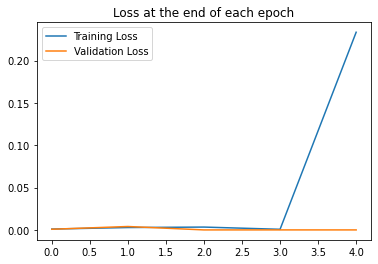

In [38]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label = 'Validation Loss')
plt.title('Loss at the end of each epoch')
plt.legend()
plt.show()

While there may be some overfitting of the training data, there is far less than we saw with the ANN model.

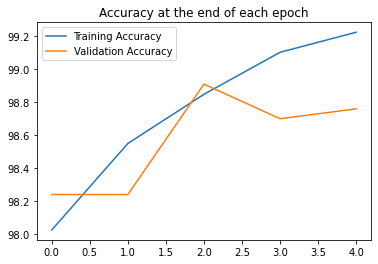

In [40]:
plt.plot([t/600 for t in train_correct], label = 'Training Accuracy')
plt.plot([t/100 for t in test_correct], label = 'Validation Accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()
plt.show()

Recall that our [784,120,84,10] ANN returned an accuracy of 97.25% after 10 epochs. And it used 105,214
parameters to our current 60,074.

In [43]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [45]:
with torch.no_grad():
    correct = 0
    for x_test, y_test in test_load_all:
        y_val = model(x_test)
        predicted=torch.max(y_val, 1)[1]
        correct+=(predicted==y_test).sum()

In [49]:
corr_pred= correct.item()/len(test_data)

In [50]:
print(f'The correct Prediction is: {corr_pred*100:.2f}%')

The correct Prediction is: 98.76%


### Display the confusion matrix

In [42]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[   1    0    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0    0    0    0    0]
 [   0    0    1    0    0    0    0    0    0    0]
 [   0    0    0    1    0    0    0    0    0    0]
 [   0    0    0    0    1    0    0    0    0    0]
 [   0    0    0    0    0    1    0    0    0    0]
 [   0    0    0    0    0    0    1    0    0    0]
 [   0    0    0    0    0    0    0    1    0    0]
 [   0    0    0    0    0    0    0    0    1    0]
 [   0    0    0    0    0    0    0    0    0    1]]


### Run a new image (single image)through the model

We can also pass a single image through the model to obtain a prediction. Pick a number from 0 to 9999, assign
it to "x", and we'll use that value to select a number from the MNIST test set.

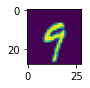

In [53]:
x=2019
plt.figure(figsize=(1,1))
plt.imshow(test_data[x][0].reshape(28,28))#, cmap='gist_yarg')

In [54]:
# Let's predict the new image
model.eval()
with torch.no_grad():
    new_pred = model(test_data[x][0].view(1,1,28,28)).argmax()
print('Predicted Value:', new_pred.item())    

Predicted Value: 9
